In [156]:
import requests
from pyproj import Proj
import matplotlib.pyplot as plt
import time
import pandas as pd
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline
import os
import geopandas

# Modified from this Tutorial: http://mattmurray.net/unlocking-the-power-of-geospatial-data-with-geopandas/

In [157]:
#### Workspace Setup
## Establish Directory Heirarchy
projDir = os.path.dirname(os.getcwd())
dataDir = os.path.join(projDir, 'Data')

## Load API keys as environment variables
# load_dotenv(os.path.join(projDir, '/API Keys.env'))
googleApiKey = pd.read_csv('/Users/stephenscherrer/Desktop/API Keys.csv', header = None).loc[0,1]
# print(googleApiKey)

In [474]:
## Defining Map Limits
xy = [[-122.53,37.81], [-122.35, 37.70]] # List containing 2 sub-lists. Each Sublist consists of a lat and lon coordinate

In [475]:
os.listdir(dataDir)
dataRaw = pd.read_csv(os.path.join(dataDir, 'interim/lat_lon_cost_time.csv'))
dataRaw = dataRaw.filter(dataRaw.columns[1:len(dataRaw.columns)], axis = 1)

## Remove Data Outside of Our Plotting Region
# print(dataRaw.shape) # (2209, 5)
dataRaw = dataRaw.loc[(
    (dataRaw.lat >= min([xy[0][1], xy[1][1]])) & (dataRaw.lat <= max([xy[0][1], xy[1][1]])) &  # Filter by lat
    (dataRaw.lon >= min([xy[0][0], xy[1][0]])) & (dataRaw.lon <= max([xy[0][0], xy[1][0]])) # Filter by lon
    ), :]
# print(dataRaw.shape) # (713, 5)

In [476]:
dataRaw['geometry'] = dataRaw.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
dataRaw.sample(5)
type(dataRaw)

pandas.core.frame.DataFrame

In [477]:
geo_transit_data = geopandas.GeoDataFrame(dataRaw, geometry='geometry')
geo_transit_data.crs = {'init': 'epsg:4326'}
geo_transit_data.sample(5)
type(geo_transit_data)

geopandas.geodataframe.GeoDataFrame

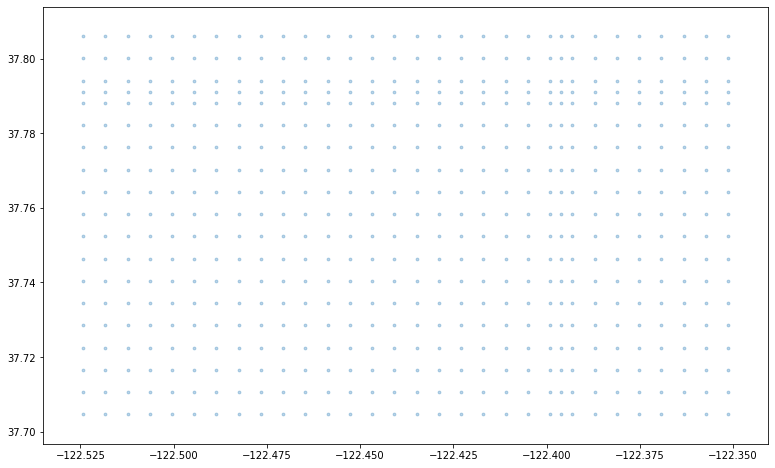

In [478]:
geo_transit_data.plot(figsize=(13,10), marker="o", markersize=8,  alpha=0.3)
plt.show()

In [479]:
## SF JSON Data from https://github.com/codeforamerica/click_that_hood
sf = geopandas.read_file(os.path.join(dataDir, 'external/sf.geojson'))
sf.crs = {'init': 'epsg:4326'}
sf = sf.rename(columns={'geometry': 'geometry','nhood':'neighborhood_name'}).set_geometry('geometry')
sf.sample(5)

,name,cartodb_id,created_at,updated_at,geometry
16,Potrero Hill,32,2013-02-10T05:44:04,2013-02-10T05:44:04,"MULTIPOLYGON (((-122.37996 37.75206, -122.3827..."
35,Outer Sunset,26,2013-02-10T05:44:04,2013-02-10T05:44:04,"MULTIPOLYGON (((-122.47601 37.74868, -122.4758..."
23,Russian Hill,4,2013-02-10T05:44:04,2013-02-10T05:44:04,"MULTIPOLYGON (((-122.42095 37.80897, -122.4206..."
29,Parkside,14,2013-02-10T05:44:04,2013-02-10T05:44:04,"MULTIPOLYGON (((-122.46964 37.73855, -122.4706..."
31,Ocean View,16,2013-02-10T05:44:04,2013-02-10T05:44:04,"MULTIPOLYGON (((-122.45912 37.70822, -122.4597..."


AttributeError: module 'matplotlib.pyplot' has no attribute 'patch'

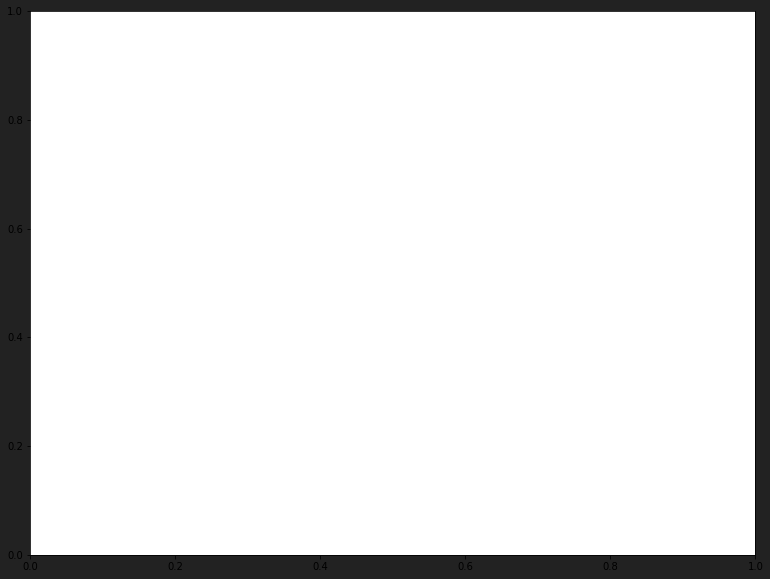

In [497]:
fig, ax = plt.subplots(1, figsize=(13,10), facecolor = '#222222')
fig.patch.set_facecolor('#222222')

gtp = geo_transit_data.plot(ax = ax, figsize=(13,10), marker="s", markersize=400,  alpha=1, cmap='cool', column = 'time', legend = True)
sf_map = sf.plot(ax=gtp, color='gray', alpha = 0.4)
ax.set_title("San Francisco Commute Times")
plt.show()

In [166]:
## Join our transit times table and our map of SF neighborhoods 
combined = geopandas.tools.sjoin(geo_transit_data, sf, how='left')
combined.sample(5)

,lat,lon,address,cost,time,geometry,index_right,name,cartodb_id,created_at,updated_at
155,37.674822,-122.446785,"Hillside Boulevard, California, 94014, us",5.25,83.183333,POINT (-122.44679 37.67482),NaN,NaN,NaN,NaN,NaN
1313,37.811970,-122.273859,NaN,NaN,23.900000,POINT (-122.27386 37.81197),NaN,NaN,NaN,NaN,NaN
78,37.662896,-122.351378,"South San Francisco, California, us",NaN,NaN,POINT (-122.35138 37.66290),NaN,NaN,NaN,NaN,NaN
924,37.770230,-122.351378,NaN,NaN,14.416667,POINT (-122.35138 37.77023),NaN,NaN,NaN,NaN,NaN
1516,37.841785,-122.458711,NaN,NaN,47.966667,POINT (-122.45871 37.84179),NaN,NaN,NaN,NaN,NaN


In [167]:
## Get mean transit time per neighborhood
neighborhood_counts = combined.groupby('name')['time'].mean().reset_index()
neighborhood_counts.columns = ['name','time']
neighborhood_counts = neighborhood_counts.sort_values(by='time', ascending=False)

In [168]:
## Merge neighborhood count data and map of SF neighborhoods
chloropleth_data = neighborhood_counts.merge(sf)
chloropleth_data = geopandas.GeoDataFrame(chloropleth_data, geometry='geometry')
chloropleth_data.crs = {'init': 'epsg:4326'}

[]

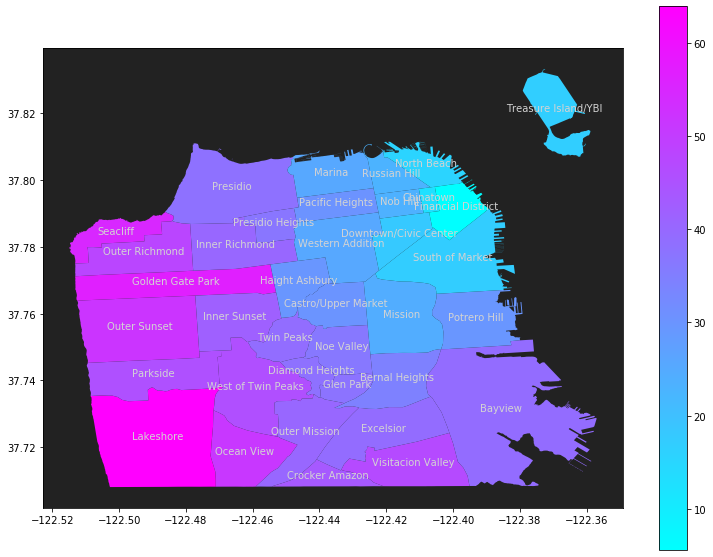

In [429]:
## Plot map data
fig = chloropleth_data.plot(column='time', cmap='cool', figsize=(13,10), legend = True)
fig.patch.set_facecolor('#222222')

## Adding neighborhood name
for idx, row in chloropleth_data.iterrows():
    ### Estimating center of polygon using mean of given coordiantes
    
    ### Add figure annotation
    fig.annotate(s=row['name'], xy = (chloropleth_data.geometry[idx].centroid.x,chloropleth_data.geometry[idx].centroid.y) , # xy=(lon, lat),
                horizontalalignment ='center', color = '#D3D3D3')



In [430]:
## Saving figure to Reports/Figures Directory
fig.figure.savefig(os.path.join(projDir, 'Reports/Figures/neighborhoodMap.pdf'), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

/Users/stephenscherrer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  after removing the cwd from sys.path.
